# **XAI for Heart Disease Dataset**

## IF5153 Natural Language Processing

- `13522070`
- `13522072`
- `13522116`

eXplainable AI (XAI) adalah pendekatan untuk membuat model pembelajaran mesin lebih transparan, sehingga hasil prediksi yang biasanya tersembunyi dalam “black-box” dapat dipahami oleh manusia.

Dengan XAI, proses “black-box” yang ada di balik model AI dapat dijelaskan sehingga pengguna dapat memahami dasar pengambilan keputusan model dan menumbuhkan kepercayaan terhadap sistem AI. Khususnya pada dataset penyakit jantung, XAI memungkinkan tenaga medis untuk meninjau prediksi model, memverifikasi relevansi faktor-faktor risiko, dan memastikan bahwa keputusan klinis yang dihasilkan dapat dipertanggungjawabkan.

# **Install and Import Library**

In [ ]:
!pip install eli5 --quiet
!pip install pdpbox --quiet
!pip install shap --quiet

In [2]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from xgboost import XGBClassifier, plot_importance
import warnings
import eli5
import shap
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

Reading the data

In [ ]:
data = pd.read_csv('./heart_disease.csv')
data.head(5)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0

In [4]:
data.describe()

age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    2.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    2.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    2.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    3.000000  140.000000  276.000000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean     0.996633  149.599327    0.326599    1.055556    0.602694    0.676768   
std      0.994914   22.941562    0.469761    1.166123    0.618187    0.938965   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      2.000000  166.000000    1.000000    1.600000    1.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    3.000000   

             thal   condition  
count  297.000000  297.000000  
mean     0.835017    0.461279  
std      0.956690    0.499340  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      2.000000    1.000000  
max      2.000000    1.000000

In [5]:
data.shape

(297, 14)

In [6]:
heart = data.copy()

In [7]:
target = 'condition'
features_list = list(heart.columns)
features_list.remove(target)

In [8]:
y = heart.pop('condition')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(heart, y, test_size=0.2, random_state=33)
X_train.shape, X_test.shape

((237, 13), (60, 13))

In [10]:
%%time

# ML in two lines ;)
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)

[07:12:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 222 ms, sys: 4.07 ms, total: 226 ms
Wall time: 71.7 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
# make predictions for test data
xgb_predictions = xgb.predict(X_test)

## Permutation Importance

In [12]:
import eli5
from eli5.sklearn import PermutationImportance

In [13]:
eli5.show_weights(xgb.get_booster(), top=15)

Diagram ini menunjukkan fitur-fitur paling penting dari dataset Penyakit Jantung. Tiga fitur terpenting adalah sebagai berikut:

1. **cp (Tipe Nyeri Dada / Chest Pain Type)** – Terdapat empat tipe angina, tergantung pada jumlah gejala yang dialami pasien:
   - 0 – **Typical Angina** – Memiliki semua 3 gejala utama angina
   - 1 – **Atypical Angina** – Memiliki 2 dari 3 gejala utama angina
   - 2 – **Non-Anginal Pain** – Memiliki satu gejala
   - 3 – **Asimtomatik** – Tidak menunjukkan gejala

   Tingkat keparahan Angina:

   ```
   Typical Angina < Atypical Angina < Non-Anginal Pain < Asimtomatik
   ```

2. **thal (Tes Thallium / Thallium Test)** – Tes thallium digunakan untuk mengecek seberapa banyak darah mencapai bagian-bagian berbeda dari jantung menggunakan tracer radioaktif. Tes ini membantu dokter menilai suplai darah:
   - 0 – Hasil normal (tidak ada komplikasi)
   - 1 – **Fixed Defect** – Suplai darah tersumbat di satu atau lebih bagian jantung
   - 2 – **Reversible Defect** – Suplai darah tersumbat di beberapa bagian, tetapi akan kembali normal setelah beberapa waktu, sehingga tidak permanen

3. **ca (Jumlah Pembuluh Tersumbat / Number of Blocked Vessels)** – Jantung memiliki tiga pembuluh utama untuk suplai darah. Dengan angiografi, dokter dapat melihat berapa banyak pembuluh yang tersumbat:
   - 0 – Tidak ada pembuluh yang tersumbat
   - 1 – 1 pembuluh tersumbat
   - 2 – 2 pembuluh tersumbat
   - 3 – 3 pembuluh tersumbat

In [14]:
tgt = 6
print('Reference:', y_test.iloc[tgt])
print('Predicted:', xgb_predictions[tgt])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[tgt], 
                     feature_names=list(heart.columns), show_feature_values=True)

Reference: 1
Predicted: 1


## Analisis Fitur Penting pada Prediksi Penyakit Jantung

Sebagai contoh lokal, dapat dilihat bahwa empat fitur teratas yang paling berkontribusi terhadap prediksi penyakit jantung adalah: **oldpeak, ca, cp, dan thal**.

**Oldpeak**, yang menempati posisi paling penting dalam prediksi ini, berkaitan dengan hasil pemeriksaan elektrokardiogram (EKG) pasien. Jika hasil EKG menunjukkan **ST Depression** (menandakan adanya iskemia miokard pada pasien), nilai *oldpeak* mencerminkan tingkat depresi ST tersebut. Semakin besar depresi, semakin tinggi kemungkinan pasien mengalami penyakit jantung.



In [15]:
%%time

# we need to retrain a new model with arrays
# as eli5 has a bug with Dataframes and XGBoost
# cf. https://github.com/TeamHG-Memex/eli5/pull/261
xgb_array = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb_array.fit(X_train.values, y_train)

[07:12:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 176 ms, sys: 3.85 ms, total: 180 ms
Wall time: 47.8 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
model = DecisionTreeClassifier(random_state=1)
model = model.fit(X_train, y_train)

In [17]:
permutation = PermutationImportance(model, random_state=33).fit(X_train, y_train)

In [18]:
eli5.show_weights(permutation, feature_names = features_list, top=30)

## PDP

In [19]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

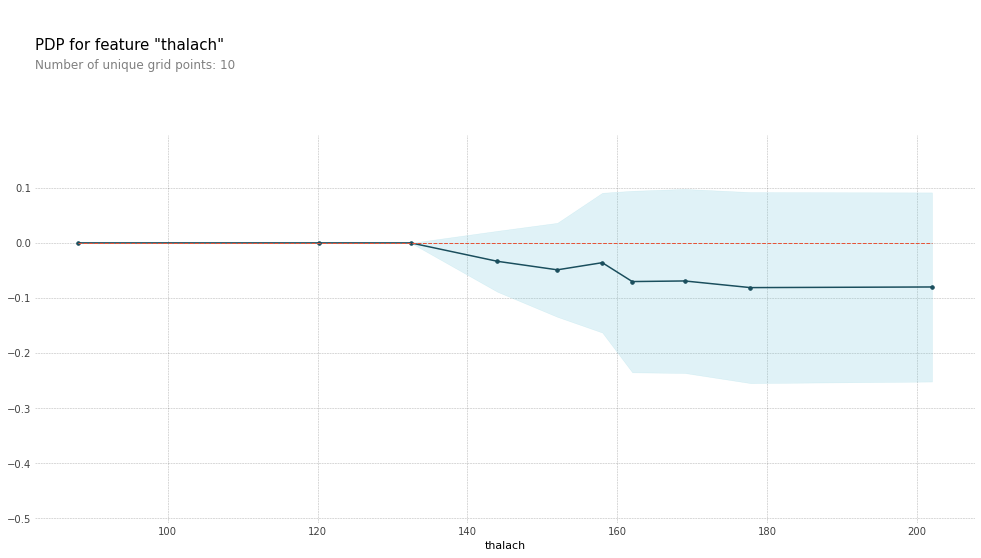

In [20]:
plot_pdp(xgb, X_train, 'thalach')

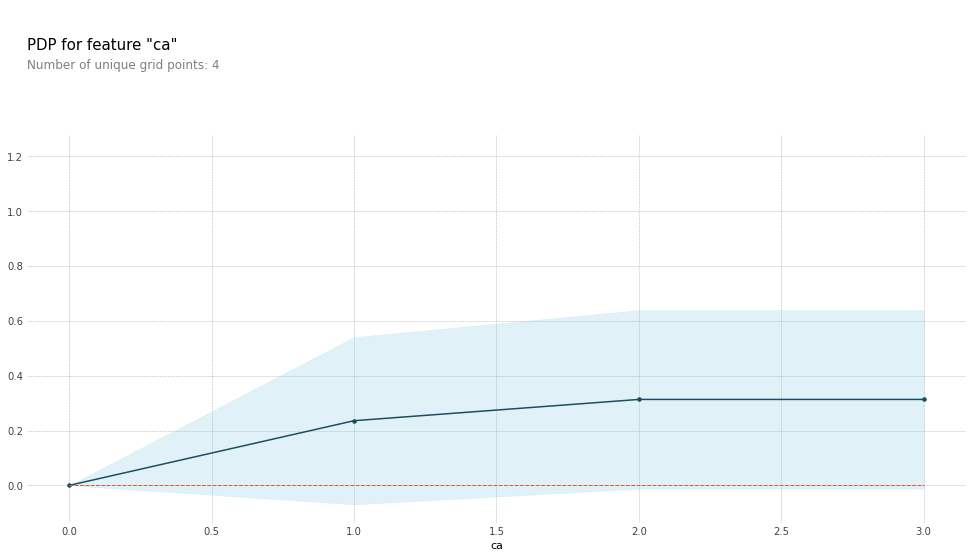

In [21]:
plot_pdp(xgb, X_train, 'ca')

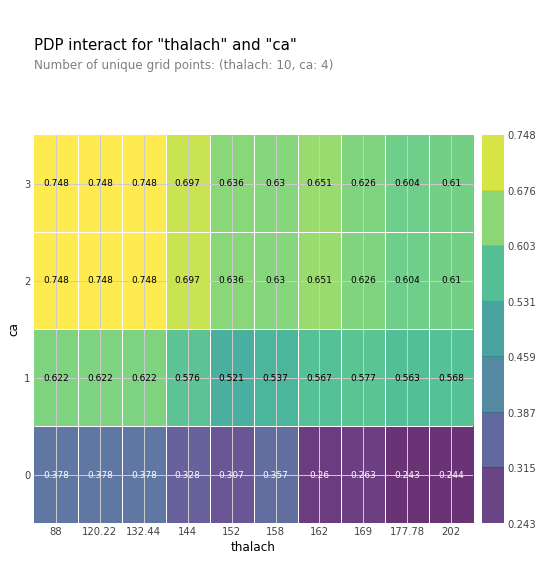

In [22]:
features_to_plot = ['thalach', 'ca']
inter1  =  pdp.pdp_interact(model=xgb, dataset=X_train, model_features=features_list, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

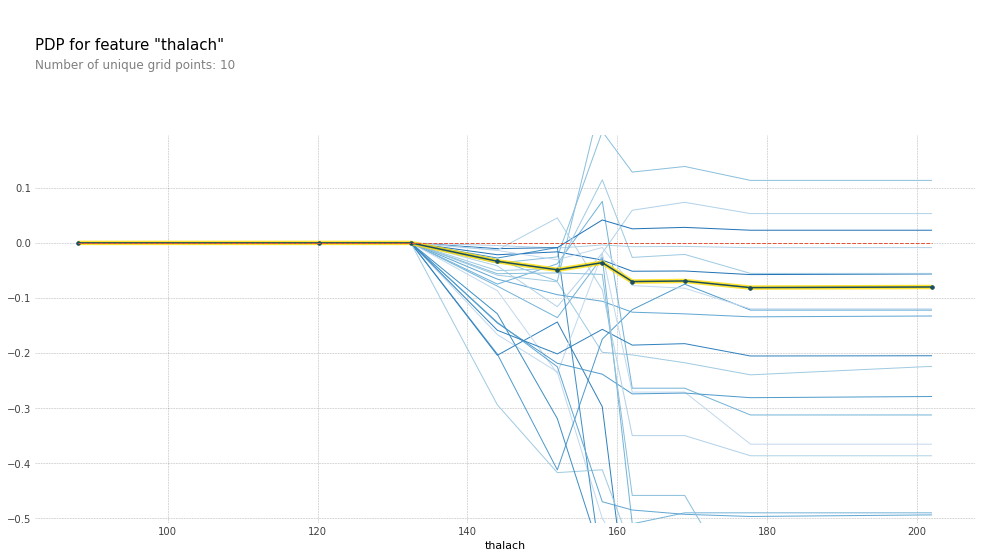

In [23]:
plot_pdp(xgb, X_train, 'thalach', cluster_flag=True, nb_clusters=24, lines_flag=True)

In [ ]:
!conda install -c conda-forge Skater -y --quiet

In [25]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [26]:
interpreter = Interpretation(training_data=X_test, feature_names=features_list)
im_model = InMemoryModel(xgb.predict_proba, examples=X_train, target_names=['Disease', 'No Disease'])

In [ ]:
predictions = xgb_array.predict_proba(X_test.values)

## LIME

In [28]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(X_test.values, feature_names=features_list, discretize_continuous=True, class_names=['No disease', 'Disease'])

In [29]:
tgt = 1
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 0
Predicted: [0.9983744  0.00162558]


## Penjelasan Prediksi Menggunakan LIME

Pada contoh lokal ini, digunakan LIME untuk menjelaskan prediksi model. Hasil akhir prediksi model adalah **0** (Pasien tidak menderita penyakit jantung). Dari sini dapat diamati nilai-nilai fitur yang memberikan kontribusi terhadap prediksi ini.

Tiga fitur teratas dan penjelasannya:

1. **ca = 0**  
   Hasil angiografi menunjukkan tidak ada pembuluh jantung yang tersumbat. Hal ini merupakan indikator positif karena pembuluh tersumbat dapat mengganggu aliran darah dan menimbulkan masalah seperti angina. Tidak adanya penyumbatan menunjukkan kondisi jantung yang sehat.

2. **thal = 0**  
   Hasil tes Thallium untuk mengevaluasi aliran darah jantung menunjukkan tidak ada kelainan sehingga hasilnya normal. Hal ini menegaskan bahwa suplai darah ke jantung berjalan dengan baik.

3. **cp = 2**  
   Pasien mengalami nyeri Non-Anginal, yang lebih ringan dibandingkan nyeri asimtomatik. Hal ini menunjukkan bahwa gejala nyeri dada yang dialami pasien tidak menandakan kondisi jantung yang serius.

In [30]:
tgt = 6
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [1.4603138e-04 9.9985397e-01]


## Contoh Prediksi Pasien dengan Penyakit Jantung

Pada contoh lain yang bersifat kontras, model memprediksi bahwa pasien **menderita penyakit jantung**. Berikut tiga fitur teratas yang memberikan kontribusi terbesar terhadap prediksi ini:

1. **ca = 2**  
   Hasil angiografi menunjukkan bahwa **dua dari tiga pembuluh jantung tersumbat**. Kondisi ini sangat mengganggu aliran darah masuk dan keluar jantung, sehingga risiko penyakit jantung menjadi tinggi.

2. **thal = 2**  
   Tes Thallium menunjukkan adanya **defek pada aliran darah jantung**, sehingga suplai darah tidak optimal. Hasil ini sejalan dengan temuan sebelumnya terkait dua pembuluh yang tersumbat.

3. **oldpeak = 2.80**  
   Nilai ST Depression pada hasil elektrokardiogram cukup tinggi. Semakin besar depresi ST pada EKG, semakin tinggi kemungkinan pasien mengalami penyakit jantung.


In [31]:
tgt = 15
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [0.03760159 0.9623984 ]


## Contoh Prediksi Kasus Ambigu

Berbeda dengan dua kasus sebelumnya, di kasus ini model memprediksi pasien **menderita angina**, tetapi hasilnya tidak terlalu jelas. Berikut tiga fitur teratas yang memengaruhi prediksi:

1. **ca = 0**  
   Hasil angiografi menunjukkan **tidak ada pembuluh yang tersumbat**, yang merupakan indikasi kondisi jantung yang sehat. Faktor ini mendorong model untuk mempertimbangkan bahwa pasien mungkin **tidak memiliki penyakit jantung**.

2. **thal = 2**  
   Berlawanan dengan hasil ca, tes Thallium menunjukkan adanya **defek pada suplai darah dan sel jantung** pasien. Kondisi ini mencerminkan bahwa dalam kenyataannya, hasil pemeriksaan seringkali bersifat **campuran** dan tidak selalu konsisten.

3. **cp = 3**  
   Pasien mengalami **nyeri dada tipe 3 (asimtomatik)**. Meskipun terdengar kontradiktif, nyeri asimtomatik sebenarnya termasuk **yang paling serius** dari empat tipe nyeri dada. Hal ini mendorong model untuk memprediksi bahwa pasien memiliki **penyakit jantung**.


## SHAP

In [32]:
# pip install shap
import shap

# load JS visualization code to notebook
shap.initjs()

In [33]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [34]:
X_shap = pd.DataFrame(shap_values)
X_shap.head()

0         1         2         3         4         5         6   \
0  0.669860  0.482459  0.620434 -1.126800 -0.374257  0.062994 -0.680173   
1 -1.294715 -0.493515 -0.662293 -0.133700 -0.450159  0.029637 -0.192750   
2  0.028315 -0.710275  1.088892  0.558033  0.346271 -0.139676  0.310020   
3 -0.049543  0.313959  0.943176  0.082306  0.380460  0.065999 -0.398400   
4  0.018207 -0.749259  1.222633  0.544088  0.082887  0.032069  0.396871   

         7         8         9         10        11        12  
0 -0.937682 -0.053942 -2.054053 -0.233142  0.804340  0.359287  
1 -0.637688 -0.210133 -0.352575  0.916539 -1.310680 -1.164720  
2  0.610800  0.753798  1.154980  0.420168  2.170985  1.290934  
3  0.580469  0.752070  1.561530  0.518611  1.678789  1.228367  
4 -0.113106 -0.263104  1.119788  0.311731  2.392574  0.986050

In [35]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  -0.4635163


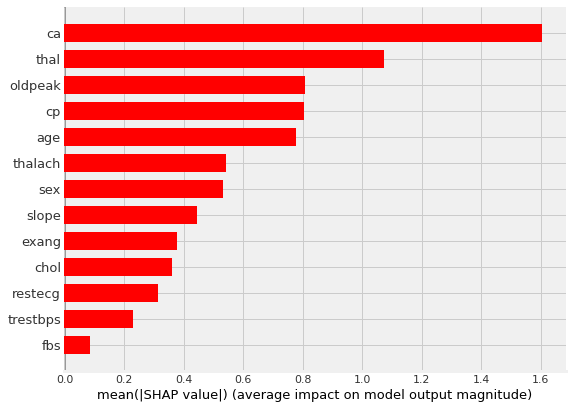

In [36]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red')


## Fitur Berdasarkan SHAP

Dengan menggunakan SHAP untuk menilai kontribusi fitur, fitur-fitur yang paling berpengaruh terhadap prediksi antara lain: **ca, thal, cp, dan oldpeak**.

In [37]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [38]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[6,:], X_test.iloc[6,:])

In [39]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[15,:], X_test.iloc[15,:])

## Analisis Kasus Ambigu Menggunakan SHAP

Setelah meninjau dua kasus ekstrem sebelumnya, kterdapat sebuah kasus di mana model memprediksi pasien **menderita angina**, namun hasilnya tidak terlalu jelas. Berikut tiga fitur teratas yang memengaruhi prediksi:

1. **ca = 0**  
   Hasil angiografi menunjukkan **tidak ada pembuluh yang tersumbat**, yang merupakan indikator positif. Faktor ini mendorong model untuk mempertimbangkan bahwa pasien **tidak memiliki penyakit jantung**.

2. **thal = 0**  
   Berlawanan dengan hasil ca, tes Thallium menunjukkan adanya beberapa **defek pada suplai darah dan sel jantung** pasien. Hal ini menunjukkan bahwa dalam praktik nyata, hasil pemeriksaan seringkali bersifat **campuran**.

3. **cp = 3**  
   Pasien mengalami **nyeri dada tipe 3 (asimtomatik)**. Meskipun terdengar kontradiktif, nyeri asimtomatik termasuk **yang paling serius** dari empat tipe nyeri dada, sehingga memengaruhi model untuk memprediksi adanya penyakit jantung.

---

Dengan menggunakan **SHAP**, untuk kasus yang tidak ekstrem, terlihat kombinasi nilai fitur **merah (meningkatkan risiko)** dan **biru (menurunkan risiko)** dari diagram yang ditampilkan. Ditinjau dari kasus-kasus tersebut secara individu:

1. **Fitur yang paling berpengaruh terhadap prediksi pasien memiliki penyakit jantung**:  
   - **thal = 2** → menunjukkan adanya defek pada suplai darah dan kualitas sel jantung pasien.  
   - **cp = 3** → nyeri dada tipe asimtomatik, yang merupakan tipe paling serius sehingga model meyakini adanya penyakit jantung.  
   - **chol = 307** → kadar kolesterol tinggi dapat menyebabkan penyumbatan pembuluh darah jantung dan menurunkan aliran darah secara keseluruhan.

2. **Fitur yang paling berpengaruh terhadap prediksi pasien tidak memiliki penyakit jantung**:  
   - **ca = 0** → tidak ada pembuluh jantung yang tersumbat. Hal ini mennjadi faktor paling signifikan yang menandakan kondisi jantung sehat.


In [40]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

## Global Prediksi Model Menggunakan SHAP

Nilai dasar (**base value**) sebesar **-0,3918** diperoleh dari perhitungan SHAP. Nilai ini memiliki arti sebagai berikut:  

- Jika total kontribusi fitur **lebih besar dari -0,3918**, model memprediksi bahwa pasien **menderita penyakit jantung**.  
- Jika total kontribusi fitur **lebih kecil dari -0,3918**, model memprediksi bahwa pasien **tidak menderita penyakit jantung**.  

Pada grafik, bagian **biru** menurunkan prediksi, sedangkan bagian **merah** meningkatkan prediksi. Artinya, kasus dengan **lebih banyak fitur berwarna merah** cenderung diprediksi sebagai **1 (pasien menderita penyakit jantung)**, dan sebaliknya, lebih banyak fitur biru cenderung menghasilkan prediksi **0 (tidak menderita)**.


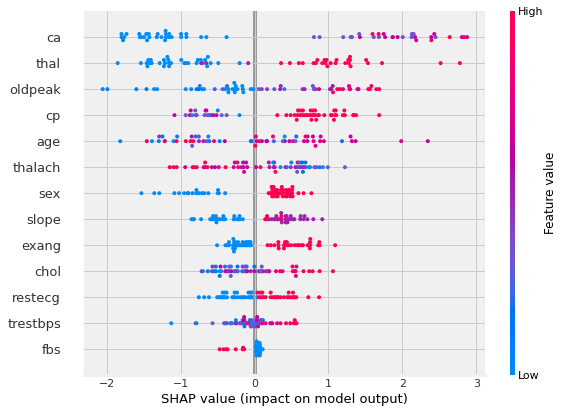

In [41]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

## Visualisasi Dampak Fitur pada Prediksi Menggunakan Scatter Plot SHAP

Dengan **scatter plot**, dapat dilihat pengaruh masing-masing fitur terhadap prediksi model pada berbagai nilai. Warna titik mewakili nilai fitur:  

- **Biru** → nilai rendah  
- **Ungu** → nilai median  
- **Merah** → nilai tinggi  

Sebagai contoh pada fitur **ca**:  
- Titik berwarna biru menunjukkan nilai SHAP **negatif**, menandakan bahwa ketika **tidak ada pembuluh yang tersumbat**, kemungkinan pasien memiliki penyakit jantung **rendah**.  
- Titik berwarna merah atau ungu menunjukkan nilai SHAP **positif**, yang berarti bahwa seiring bertambahnya jumlah pembuluh yang tersumbat, **kemungkinan pasien menderita penyakit jantung meningkat**.

Visualisasi ini membantu memahami **hubungan fitur dan prediksi model** secara intuitif dan memudahkan interpretasi untuk setiap nilai fitur.

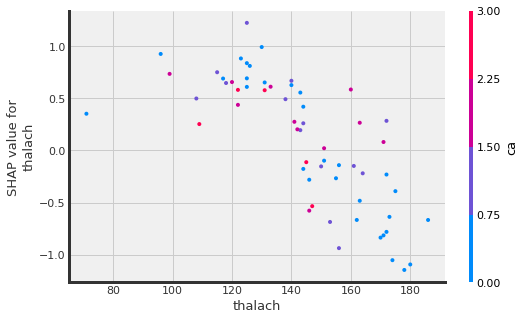

In [42]:
shap.initjs()
shap.dependence_plot(ind='thalach', interaction_index='ca',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

Scatter plot ini menampilkan hubungan antara dua fitur sekaligus dengan nilai SHAP.  

- **Sumbu X**: `thalach` (detak jantung maksimum)  
- **Sumbu Y**: Nilai SHAP  
- **Warna titik**: Nilai fitur `ca`  

Dari plot ini, terlihat bahwa **nilai SHAP cenderung rendah ketika nilai `ca` rendah**. Selain itu, terdapat **tren menurun ringan pada nilai SHAP seiring meningkatnya `thalach`**, menunjukkan bahwa detak jantung maksimum juga berpengaruh terhadap prediksi model, meskipun pengaruhnya lebih halus dibandingkan `ca`.
